In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

all_data = {}

for file in glob.glob('./Voter Registration Data/*'):
    data = pd.read_excel(file)
    date = data.iloc[0,0][-4:]
    all_data[date] = data

In [2]:
def clean(raw_array):
    raw_array = raw_array.dropna()
    raw_array.columns = raw_array.loc[3]
    raw_array = raw_array.drop(3)
    raw_array.reset_index(drop=True, inplace=True)
    raw_array.columns.name = None

    int_cols = raw_array.columns[3:]
    str_cols = raw_array.columns[:3]

    for col in int_cols:
        raw_array[col] = raw_array[col].astype('int64')

    for col in str_cols:
        raw_array[col] = raw_array[col].str.strip()

    return raw_array

In [3]:
clean_data = {}

for date in all_data:
    clean_data[date] = clean(all_data[date])

with pd.ExcelWriter('registration_data_cleaned.xlsx', engine='openpyxl') as writer:
    for date, data in clean_data.items():
        data.to_excel(writer, sheet_name=date)

In [4]:
first_year = list(clean_data.keys())[0]
all_totals = clean_data[first_year].loc[clean_data[first_year]['STATUS'].str.contains('Total'), ['REGION']]
all_totals['COUNTY'] = clean_data[first_year].loc[clean_data[first_year]['STATUS'].str.contains('Total'), ['COUNTY']]

for date in clean_data:
    month_data = clean_data[date]
    all_totals[date] = month_data.loc[month_data['STATUS'].str.contains('Total'), ['TOTAL']]

all_totals.reset_index(drop=True, inplace=True)

all_totals

,REGION,COUNTY,2019,2020,2021,2022,2023,2024
0,Outside NYC,Albany,207911,217145,211585,216535,209650,218694
1,Outside NYC,Allegany,26292,27563,27342,27626,27269,28234
2,Outside NYC,Broome,131262,138660,136682,138643,140940,147051
3,Outside NYC,Cattaraugus,47516,49662,49035,49694,50762,51789
4,Outside NYC,Cayuga,48206,50620,49934,50797,50540,51948
...,...,...,...,...,...,...,...,...
57,Within NYC,Bronx,833172,867716,873909,794018,783871,808496
58,Within NYC,Kings,1637055,1735372,1742176,1626980,1610235,1678785
59,Within NYC,New York,1197797,1250793,1262237,1129673,1106918,1169313
60,Within NYC,Queens,1282887,1366759,1369875,1311625,1298353,1354339


In [ ]:
# A warning appears here because we are using .pct_change() on dtype int64. This is fixed if we set the dtype to float64.
all_perc = all_totals.transpose().tail(-2).pct_change() * 100

all_perc = all_perc.round(2)
all_perc.columns = all_totals['COUNTY'] 

quantiles_arr = []
outliers = []

dates = list(all_totals)[2:]

for date in dates:
    q1 = all_perc.transpose()[date].quantile(0.25).round(2)
    q2 = all_perc.transpose()[date].quantile(0.5).round(2)
    q3 = all_perc.transpose()[date].quantile(0.75).round(2)

    quantiles_arr.append([q1, q2, q3])

quantiles = pd.DataFrame(quantiles_arr)
quantiles.columns = ['Q1', 'Median', 'Q3']
quantiles.index = dates

all_perc = pd.concat([all_perc,quantiles], axis=1)

all_perc.transpose()

In [6]:
perc_T = all_perc.transpose()

outliers = []

for date, data in perc_T.items():
    q1 = data['Q1']
    q3 = data['Q3']
    outlier_df = perc_T[(perc_T[date] < q1 - 1.5 * (q3-q1)) | (perc_T[date] > q3 + 1.5 * (q3-q1))]
    outliers += list(outlier_df.index)

outliers

['Cortland',
 'Hamilton',
 'Livingston',
 'Rensselaer',
 'Jefferson',
 'Oswego',
 'Essex',
 'Bronx',
 'Kings',
 'New York',
 'Queens',
 'Richmond',
 'Albany',
 'Dutchess',
 'Saratoga',
 'Wyoming',
 'Genesee',
 'Hamilton',
 'Herkimer',
 'Tompkins']

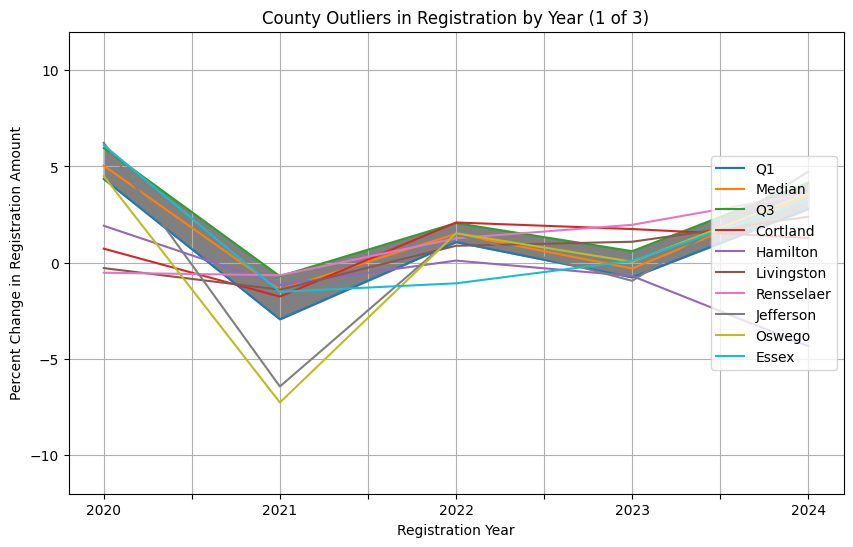

In [7]:
plt.rcParams['figure.figsize'] = (10, 6)

# Print the graph in groups of 7 for color coding

cols_to_plot = ['Q1', 'Median', 'Q3'] + outliers[:7]

years = list(all_perc.index)

all_perc[cols_to_plot].plot(
    xlabel = 'Registration Year', 
    ylabel = 'Percent Change in Registration Amount',
    title= 'County Outliers in Registration by Year (1 of 3)',
    )

plt.fill_between(all_perc.index, all_perc['Q1'], all_perc['Q3'], color='grey')
plt.ylim(-12,12)
plt.grid()
plt.legend(loc='right')
plt.show()

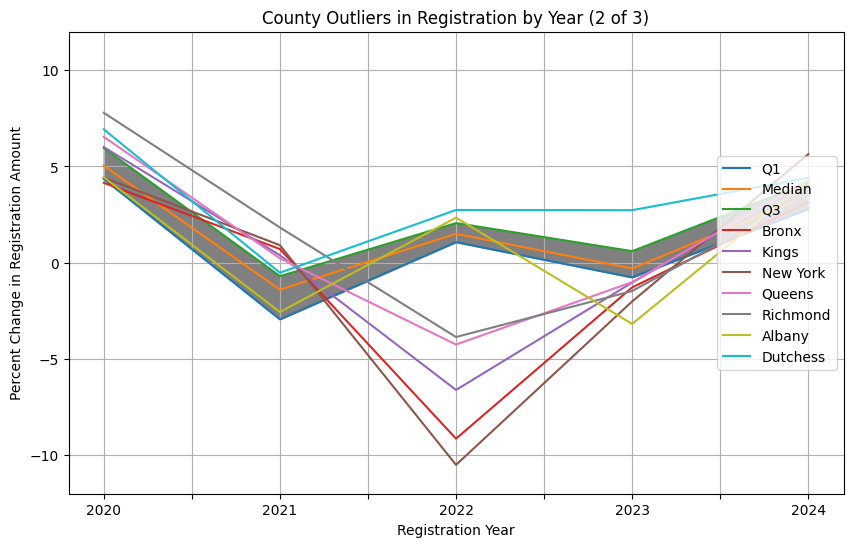

In [8]:
# Interesting: The NYC counties all had a decrease in registration during 2022, but most (except Essex) had an increase

cols_to_plot = ['Q1', 'Median', 'Q3'] + outliers[7:14]

years = list(all_perc.index)

all_perc[cols_to_plot].plot(
    xlabel = 'Registration Year', 
    ylabel = 'Percent Change in Registration Amount',
    title= 'County Outliers in Registration by Year (2 of 3)',
    )

plt.fill_between(all_perc.index, all_perc['Q1'], all_perc['Q3'], color='grey')
plt.ylim(-12,12)
plt.grid()
plt.legend(loc='right')
plt.show()

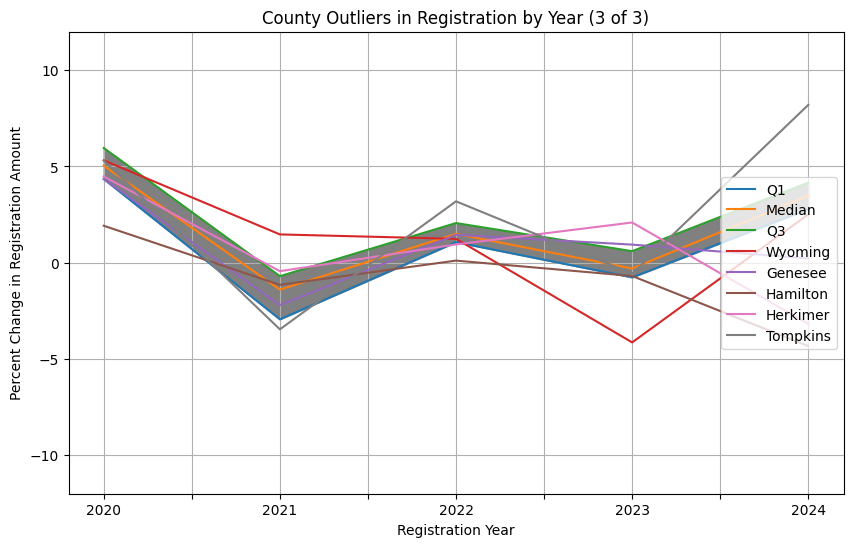

In [9]:
cols_to_plot = ['Q1', 'Median', 'Q3'] + outliers[15:]

years = list(all_perc.index)

all_perc[cols_to_plot].plot(
    xlabel = 'Registration Year', 
    ylabel = 'Percent Change in Registration Amount',
    title= 'County Outliers in Registration by Year (3 of 3)',
    )

plt.fill_between(all_perc.index, all_perc['Q1'], all_perc['Q3'], color='grey')
plt.ylim(-12,12)
plt.grid()
plt.legend(loc='right')
plt.show()